## Monte Carlo Dropout
### Playing with house prices


In this notebook we explore the estimation of both aleatoric and epistemic uncertainty through Monte Carlo Dropout. A simple perceptron is used to model the regression problem which outputs the price prediction. The same dataset from the Direct Modelling experiment is used in order to allow for the comparison of the achieved estimation of aleatoric uncertainty.

![house prices](datasets/real_estate/house_prices.png)

The decomposition of uncertainty is carried out through the application of the following entropy-based formulas:

$$ \text{Total Uncertainty (TU)} = \mathcal{H} [p(y_i | x_i, D)] = \mathcal{H} [\mathbb{E}_{p(\theta | D)} [p(y_i | x_i, \theta)] $$


$$ \text{Aleatoric Uncertainty (AU)} = \mathbb{E}_{p(\theta | D)} [\mathcal{H} [p(y_i | x_i, \theta)]] $$
$$ \text{Epistemic Uncertainty (EU)} = \text{TU} - \text{AU} $$

In [1]:
import tqdm
import math
import torch
import pandas as pd

In [2]:
import numpy as np
import seaborn as sns
from time import sleep
from pathlib import Path

from torch import nn
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# Paths, global vars
dt_folder = Path("./datasets")
dt_name = 'real_estate'

In [4]:
# Checks
assert dt_folder.exists()
assert dt_folder.is_dir()
assert (dt_folder / dt_name / (dt_name + '.csv')).exists()

#### Load Dataset

In [5]:
df = pd.read_csv(dt_folder / dt_name / (dt_name + '.csv'))

In [6]:
df

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,411,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


In [7]:
df.dtypes

No                                          int64
X1 transaction date                       float64
X2 house age                              float64
X3 distance to the nearest MRT station    float64
X4 number of convenience stores             int64
X5 latitude                               float64
X6 longitude                              float64
Y house price of unit area                float64
dtype: object

#### Prepare data

In [8]:
train, test = train_test_split(df, test_size=0.2)

In [9]:
class HouseDataset(torch.utils.data.Dataset):
    def __init__(self, df, scale=False):
        x = df.iloc[:, 1:7]
        y = df.iloc[:, 7]
        if scale:
            x = StandardScaler().fit_transform(x)
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y.values)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

#### Model

In [10]:
class MLP(nn.Module):
    def __init__(self, rates):
        super().__init__()
        self.rates = rates
        self.dropout_1 = nn.Dropout(p=rates[0])
        self.dropout_2 = nn.Dropout(p=rates[1])
        self.dropout_3 = nn.Dropout(p=rates[2])
        
        self.dense_1 = nn.Sequential(
            nn.Linear(6, 64),
            nn.ReLU()
        )
        self.dense_2 = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU()
        )
        self.dense_3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.dense_4 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.linear = nn.Linear(32, 1)
        
    def forward(self, x, training=False):
        x = self.dense_1(x)
        if training:
            x = self.dropout_1(x)
        x = self.dense_2(x)
        if training:
            x = self.dropout_2(x)
        x = self.dense_3(x)
        if training:
            x = self.dropout_3(x)
        
        x = self.dense_4(x)
        return self.linear(x)

#### Train Loop

In [11]:
epochs = 200
batch_size = 64

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
mean_batch_loss = np.array([])
torch.manual_seed(42)

dt_train = HouseDataset(train, scale=True)
train_loader = torch.utils.data.DataLoader(dt_train, batch_size=batch_size, num_workers=2)

mlp = MLP([0.5, 0.5, 0.5])
mc_loss = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

mlp.train()
mlp.to(device)

MLP(
  (dropout_1): Dropout(p=0.5, inplace=False)
  (dropout_2): Dropout(p=0.5, inplace=False)
  (dropout_3): Dropout(p=0.5, inplace=False)
  (dense_1): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
  )
  (dense_2): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
  )
  (dense_3): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
  )
  (dense_4): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [14]:
for epoch in range(epochs):
    tepoch = tqdm.tqdm(train_loader)
    tepoch.set_description(f"Epoch {epoch}")
    
    for i, obj in enumerate(tepoch):
        data, target = obj

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = mlp(data)
        # [batch_size, 1] -> [batch_size]
        output = torch.squeeze(output)
        
        out_loss = mc_loss(output, target)
        mean_batch_loss = np.append(mean_batch_loss, out_loss.item())

        out_loss.backward()
        optimizer.step()

        tepoch.set_postfix(loss=out_loss.item())
        sleep(0.1)

Epoch 199: 100%|████████████████████████| 6/6 [00:00<00:00,  7.21it/s, loss=1.45]


<AxesSubplot:>

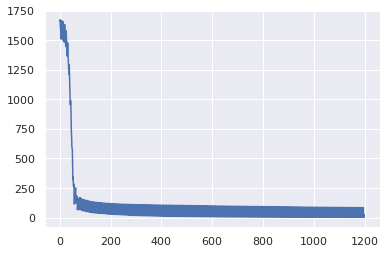

In [15]:
sns.set_theme(style="darkgrid")
sns.lineplot(data=mean_batch_loss)

#### Testing the model

In [16]:
dt_test = HouseDataset(test, scale=True)
test_loader = torch.utils.data.DataLoader(dt_test, batch_size=batch_size, num_workers=2)

In [17]:
loss = np.array([])
pred = np.array([])

In [18]:
for i, obj in enumerate(test_loader):
    data, target = obj
    data, target = data.to(device), target.to(device)
    
    output = mlp(data)
    output = torch.squeeze(output)
    l = mc_loss(output, target)
    loss = np.append(loss, l.item())
    
    p = output.squeeze().cpu().detach().numpy()
    pred = np.concatenate((pred, p))

In [19]:
loss

array([62.03661728, 89.38702393])

In [20]:
plot_df = test.copy()
plot_df['pred'] = pred
plot_df

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area,pred
392,393,2013.083,42.7,443.80200,6,24.97927,121.53874,35.3,37.052158
305,306,2013.083,16.2,289.32480,5,24.98203,121.54348,55.0,45.037388
377,378,2013.333,3.9,49.66105,8,24.95836,121.53756,56.8,48.462807
324,325,2012.667,12.4,1712.63200,2,24.96412,121.51670,31.3,25.682980
316,317,2013.250,13.3,250.63100,7,24.96606,121.54297,42.0,39.371151
...,...,...,...,...,...,...,...,...,...
280,281,2013.250,2.3,184.33020,6,24.96581,121.54086,45.4,44.710751
15,16,2013.583,35.7,579.20830,2,24.98240,121.54619,50.5,42.180462
290,291,2013.083,37.7,490.34460,0,24.97217,121.53471,37.0,36.263126
60,61,2013.417,11.0,1931.20700,2,24.96365,121.51471,21.3,24.983912


#### Uncertainty Quantification

For the quantification of uncertainty, we utilise a model based on entropy proposed in prior literature.

$$ D = \{\{x1, y1\}, \{x2, y2\}, ..., \{x_n, y_n\}\} $$

$$ TU = \mathcal{H} [\mathbb{E}_{p(\theta | D)}(p(y | x, \theta))] $$
$$ AU = \mathbb{E}_{p(\theta | D)} [\mathcal{H}(p(y | x, \theta))] $$
$$ EU = TU - AU $$

In [21]:
def mc_dropout(data_loader, net, T):
    avg_preds = []
    for n in range(T):
        avg_sample_preds = []
        
        with torch.no_grad():
            for i, obj in enumerate(data_loader):
                data, target = obj
                data, target = data.to(device), target.to(device)

                # Training flag guarantees dropout is activated
                output = net(data, training=True)
                # [batch_size, 1] -> [batch_size]
                avg_sample_preds.extend(output.squeeze().cpu().detach().numpy())
                
        avg_preds.append(np.asarray(avg_sample_preds))
    return np.asarray(avg_preds)

In [22]:
def uq_decomposition(probs, mean):
    # mean = expected value, so entropy(mean) = TU
    tu = -np.sum(mean*np.log(mean), axis=-1) # shape (n_samples,)
    
    # AU average
    au = np.mean(-np.sum(probs*np.log(probs), axis=-1), axis=0) # shape (n_samples,)

    # EU average
    eu = tu - au
    
    return tu, au, eu

In [23]:
def uq(test_loader, net, T, display=False):
    # shape (T, samples)
    preds = mc_dropout(test_loader, net, T)
    # shape (samples)
    sample_means = np.mean(preds, axis=0)
    
    # Predictive distribution moments
    mean = np.mean(sample_means)
    variance = np.var(sample_means)
    std = np.sqrt(variance)
    # Std by sample
    stds = np.std(preds, axis=0)
    
    import scipy
    norm = scipy.stats.norm(mean, std)
    prob_preds = np.asarray([norm.pdf(x) for x in preds])
    
    if display:
        sns.histplot(sample_means, bins=preds.shape[1]//2, kde=True)    
    
    tu, au, eu = uq_decomposition(prob_preds, sample_means)
    
    return mean, variance, stds, tu, au, eu

In [24]:
dt_mc = HouseDataset(test, scale=True)
mc_loader = torch.utils.data.DataLoader(dt_mc, batch_size=batch_size, num_workers=2)

Mean> 37.131725
Variance> 92.94022
Mean TU> -11247.888
Mean AU> 5.7622495665638835
Mean EU> -11253.649944879064


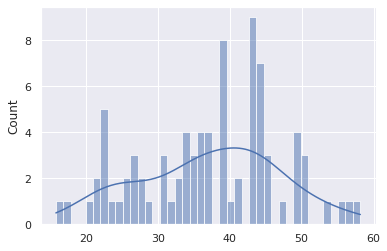

In [25]:
mean, variance, stds, tu, au, eu = uq(mc_loader, mlp, 50, display=True)
print('Mean>', mean)
print('Variance>', variance)
print('Mean TU>', tu)
print('Mean AU>', au)
print('Mean EU>', eu)

#### Plotting with uncertainty

In [26]:
plot_df_mc = test.copy()
plot_df_mc['pred'] = mean
plot_df_mc['std'] = stds
plot_df_mc

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area,pred,std
392,393,2013.083,42.7,443.80200,6,24.97927,121.53874,35.3,37.131725,14.228360
305,306,2013.083,16.2,289.32480,5,24.98203,121.54348,55.0,37.131725,13.341484
377,378,2013.333,3.9,49.66105,8,24.95836,121.53756,56.8,37.131725,19.545008
324,325,2012.667,12.4,1712.63200,2,24.96412,121.51670,31.3,37.131725,11.747578
316,317,2013.250,13.3,250.63100,7,24.96606,121.54297,42.0,37.131725,14.879110
...,...,...,...,...,...,...,...,...,...,...
280,281,2013.250,2.3,184.33020,6,24.96581,121.54086,45.4,37.131725,18.071341
15,16,2013.583,35.7,579.20830,2,24.98240,121.54619,50.5,37.131725,18.405142
290,291,2013.083,37.7,490.34460,0,24.97217,121.53471,37.0,37.131725,11.542841
60,61,2013.417,11.0,1931.20700,2,24.96365,121.51471,21.3,37.131725,12.190035


In [27]:
plot_df_mc['upper'] = plot_df_mc['pred'] + plot_df_mc['std']
plot_df_mc['lower'] = plot_df_mc['pred'] - plot_df_mc['std']

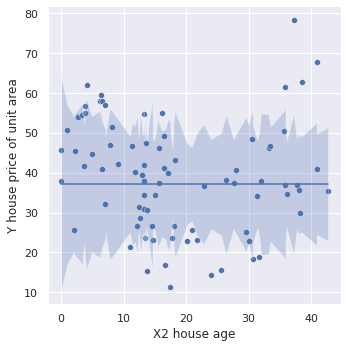

In [28]:
plot_df_mc = plot_df_mc.sort_values(by=['X2 house age'])
sns.set_theme(style="darkgrid")
sns.relplot(data=plot_df_mc, x="X2 house age", y="Y house price of unit area")
ax = sns.lineplot(data=plot_df_mc, x="X2 house age", y="pred")
ax.fill_between(plot_df_mc['X2 house age'], plot_df_mc['lower'], plot_df_mc['upper'], alpha=0.25)

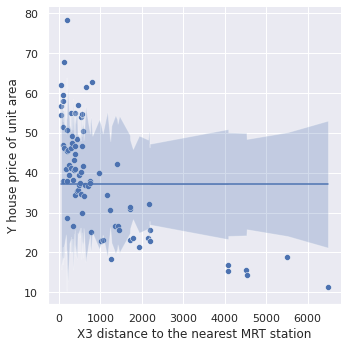

In [29]:
plot_df_mc = plot_df_mc.sort_values(by=['X3 distance to the nearest MRT station'])
sns.set_theme(style="darkgrid")
sns.relplot(data=plot_df_mc, x="X3 distance to the nearest MRT station", y="Y house price of unit area")
ax = sns.lineplot(data=plot_df_mc, x="X3 distance to the nearest MRT station", y="pred")
ax.fill_between(plot_df_mc['X3 distance to the nearest MRT station'], plot_df_mc['lower'], plot_df_mc['upper'], alpha=0.25)

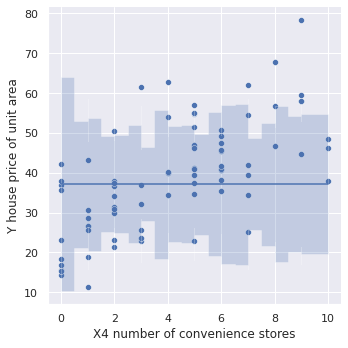

In [30]:
plot_df_mc = plot_df_mc.sort_values(by=['X4 number of convenience stores'])
sns.set_theme(style="darkgrid")
sns.relplot(data=plot_df_mc, x="X4 number of convenience stores", y="Y house price of unit area")
ax = sns.lineplot(data=plot_df_mc, x="X4 number of convenience stores", y="pred", errorbar=None)
ax.fill_between(plot_df_mc['X4 number of convenience stores'], plot_df_mc['lower'], plot_df_mc['upper'], alpha=0.25, step='mid')